In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Lab25- GoogLeNet

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate
from keras.models import Model
from google.colab import drive, files
import os

import time, datetime
start = datetime.datetime.now()
time.sleep(10)

# load
train_data_dir = '/content/drive/MyDrive/Mura Datase_50%_Training Data_100%_Test data/MURA-v1.1/train'
test_data_dir = '/content/drive/MyDrive/Mura Datase_50%_Training Data_100%_Test data/MURA-v1.1/valid'
#data_dir = pathlib.Path(data_dir)
#image_count = len(list(data_dir.glob('*/*.jpg')))

# data prep
batch_size = 64
img_height = 256
img_width = 256
trainX = tf.keras.utils.image_dataset_from_directory(train_data_dir, seed=123, image_size=(img_height, img_width), batch_size=batch_size)
testX = tf.keras.utils.image_dataset_from_directory(test_data_dir, seed=123, image_size=(img_height, img_width), batch_size=batch_size)
classes = trainX.class_names
plt.figure(figsize=(10, 10))

# model
def GoogLeNet():
  input_layer = Input(shape=(256, 256, 3))
  out = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='valid', activation='relu')(input_layer)
  out = MaxPooling2D(pool_size=(3, 3), strides=2)(out)
  out = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(out)
  out = Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = MaxPooling2D(pool_size=(3, 3), strides=2)(out)
  out = Inception_block(out, f1=64, f2_conv1=96, f2_conv3=128, f3_conv1=16, f3_conv5=32, f4=32)
  out = Inception_block(out, f1=128, f2_conv1=128, f2_conv3=192, f3_conv1=32, f3_conv5=96, f4=64)
  out = MaxPooling2D(pool_size=(3, 3), strides=2)(out)
  out = Inception_block(out, f1=192, f2_conv1=96, f2_conv3=208, f3_conv1=16, f3_conv5=48, f4=64)
  out1 = AveragePooling2D(pool_size=(5, 5), strides=3)(out)
  out1 = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(out1)
  out1 = Flatten()(out1)
  out1 = Dense(1024, activation='relu')(out1)
  out1 = Dropout(0.7)(out1)
  out1 = Dense(5, activation='softmax')(out1)
  out = Inception_block(out, f1=160, f2_conv1=112, f2_conv3=224, f3_conv1=24, f3_conv5=64, f4=64)
  out = Inception_block(out, f1=128, f2_conv1=128, f2_conv3=256, f3_conv1=24, f3_conv5=64, f4=64)
  out = Inception_block(out, f1=112, f2_conv1=144, f2_conv3=288, f3_conv1=32, f3_conv5=64, f4=64)
  out2 = AveragePooling2D(pool_size=(5, 5), strides=3)(out)
  out2 = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(out2)
  out2 = Flatten()(out2)
  out2= Dense(1024, activation='relu')(out2)
  out2 = Dropout(0.7)(out2)
  out2 = Dense(1000, activation='softmax')(out2)
  out = Inception_block(out, f1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32, f3_conv5=128, f4=128)
  out = MaxPooling2D(pool_size=(3, 3), strides=2)(out)
  out = Inception_block(out, f1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32, f3_conv5=128, f4=128)
  out = Inception_block(out, f1=384, f2_conv1=192, f2_conv3=384, f3_conv1=48, f3_conv5=128, f4=128)
  out = GlobalAveragePooling2D(name='GAPL')(out)
  out = Dropout(0.4)(out)
  out = Dense(7, activation='softmax')(out)
  model = Model(input_layer, [out, out1, out2], name='GoogLeNet')
  return model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)
  output_layer = concatenate([path1, path2, path3, path4], axis = -1)
  return output_layer

model = GoogLeNet()
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(trainX, validation_data=testX, epochs=10)
print (history.history.keys())

# y_vloss = history.history['val_loss']
# y_loss = history.history['loss']
# y_acc = history.history['accuracy']
# y_vacc = history.history['val_accuracy']

# fig, (ax1) = plt.subplots(1)
# ax1.plot(np.arange(len(y_vloss)), y_vloss, marker='.', c='red')
# ax1.plot(np.arange(len(y_loss)), y_loss, marker='.', c='blue')
# ax1.grid()
# plt.title('Model Loss')
# plt.setp(ax1, xlabel='epoch', ylabel='loss')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("./loss per epochs for cnn-graph.jpg")
# plt.show()

# fig, (ax2) = plt.subplots(1)
# ax2.plot(np.arange(len(y_vacc)), y_vacc, marker='.', c='red')
# ax2.plot(np.arange(len(y_acc)), y_acc, marker='.', c='blue')
# ax2.grid()
# plt.title('Model Accuracy') 
# plt.setp(ax2, xlabel='epoch', ylabel='accuracy')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("./accuracy per epochs for cnn-graph.jpg")
# plt.show()


# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# # plt.savefig("./accuracy per epochs for GoogleNet-graph.jpg")
# plt.show()

# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("./loss per epochs for GoogleNet-graph.jpg")
# plt.show()

# end = datetime.datetime.now()
# diff = (end - start)
# datetime.timedelta(seconds=10, microseconds=885206)

# diff_seconds = int(diff.total_seconds())
# minute_seconds, seconds = divmod(diff_seconds, 60)
# hours, minutes = divmod(minute_seconds, 60)
# hms = f"{hours}h {minutes}m {seconds}s"
# print("\nTotal Training Time for the model: ", hms)


Found 18713 files belonging to 7 classes.
Found 3217 files belonging to 7 classes.
Epoch 1/10
293/293 [==============================] - 5496s 18s/step - loss: nan - dense_4_loss: nan - dense_1_loss: nan - dense_3_loss: nan - dense_4_accuracy: 0.1277 - dense_1_accuracy: 0.1275 - dense_3_accuracy: 0.1272 - val_loss: nan - val_dense_4_loss: nan - val_dense_1_loss: nan - val_dense_3_loss: nan - val_dense_4_accuracy: 0.1445 - val_dense_1_accuracy: 0.1445 - val_dense_3_accuracy: 0.1445
Epoch 2/10
293/293 [==============================] - 94s 313ms/step - loss: nan - dense_4_loss: nan - dense_1_loss: nan - dense_3_loss: nan - dense_4_accuracy: 0.1278 - dense_1_accuracy: 0.1278 - dense_3_accuracy: 0.1278 - val_loss: nan - val_dense_4_loss: nan - val_dense_1_loss: nan - val_dense_3_loss: nan - val_dense_4_accuracy: 0.1445 - val_dense_1_accuracy: 0.1445 - val_dense_3_accuracy: 0.1445
Epoch 3/10
293/293 [==============================] - 94s 314ms/step - loss: nan - dense_4_loss: nan - dense_1_

<Figure size 720x720 with 0 Axes>

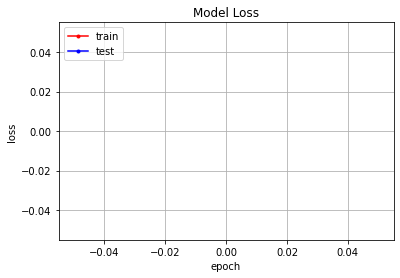

In [4]:
y_vloss = history.history['val_dense_3_loss']
y_loss = history.history['dense_3_loss']
# y_acc = history.history['accuracy']
y_acc = history.history['dense_3_accuracy']
y_vacc = history.history['val_dense_3_accuracy']



fig, (ax1) = plt.subplots(1)
ax1.plot(np.arange(len(y_vloss)), y_vloss, marker='.', c='red')
ax1.plot(np.arange(len(y_loss)), y_loss, marker='.', c='blue')
ax1.grid()
plt.title('Model Loss')
plt.setp(ax1, xlabel='epoch', ylabel='loss')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./loss per epochs for GoogleNet-graph.jpg")
plt.show()

fig, (ax2) = plt.subplots(1)
ax2.plot(np.arange(len(y_vacc)), y_vacc, marker='.', c='red')
ax2.plot(np.arange(len(y_acc)), y_acc, marker='.', c='blue')
ax2.grid()
plt.title('Model Accuracy')
plt.setp(ax2, xlabel='epoch', ylabel='accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./accuracy per epochs for GoogleNet-graph.jpg")
plt.show()



In [5]:
end = datetime.datetime.now()
diff = (end - start)
datetime.timedelta(seconds=10, microseconds=885206)

diff_seconds = int(diff.total_seconds())
minute_seconds, seconds = divmod(diff_seconds, 60)
hours, minutes = divmod(minute_seconds, 60) 
hms = f"{hours}h {minutes}m {seconds}s"
print("\nTotal Training Time for the model: ", hms)


Total Training Time for the model:  2h 25m 28s
